## The App is implemented in order to find groups for the SICSS Munich

### 1. General Information

In this notebook, I quickly outline the model on which the recommendations are made. To begin with, data is stored in `~/data/data.csv` and comprises the following categories:
-   Research Questions: A list of `k` proposed questions answered by `n` participants $ \in$ {$0,1$}
-   Method Preferences: A list of `i` proposed methods answered by `n` participants $ \in$ {$0,1$}
-   Main Preference: An indicator answered by `n` participants of wether they regard Methods (0) or Research Question (1) as more important in their project $ \in (0,1)$
-   Desired Scope of the project: An indicator answered by `n` participants of how much effort they want to put in the project $ \in (0,1)$
All relevant code for the analysis is implemented in `Recommender` of *recommend.py* which will be imported first.

In [1]:
from recommend import Recommender

When initialising the model, one can choose either to use *simulated data* or the *generated one* (if it exists) by with the `sim`-parameter.

In [2]:
model = Recommender(sim=False)

### 2. The Model


For classifying the participant into a fixed number of groups (adjustable with the `cluster_size k`), we opted for two **Bernoulli Mixture Models** which clustered participants independently based on the preferences regarding:
1.  Research Question as $(n \times k)$ matrice $X_1$
2.  Method Preferences as $(n \times i)$ matrice $X_2$

An application of such models is illustrated by [Pierre G. B. Moutounet-Cartan](https://arxiv.org/abs/2005.02931). While skipping most of the important notation and theory, we build the following model twice - for both of the matrices - and use Bayesian inference to get our parameters of interest:
1.  Priors:
    $$ P_{ij} \sim Beta(0.5,0.5)$$
    $$ R_{ij} \sim Dirichlet_k(e^{-5})$$
    $$ Z_n | R_{ij} \sim Categorical_k(R)$$
2.  Likelihood:
    $$ X_{in} | P_{ij},Z_n \sim Bernoulli(P_i,Z_n)$$
3.  Posterior: This quantity can be obtained by using Bayes Theorem:
    $$P(X|Y)=\frac{P(Y|X)\cdot P(X)}{P(Y)}$$

In [3]:
result = model.fit(cluster_size=5)

### 3. Plots explaining the Grouping procedure

As a result of the model, for each participant **i** we get a probability, that he/she belongs to a certain cluster **c**. Since we build two models for Research- and Methods interests independently, we therefore get $10$ probabilities for each participant as illustrated below in the left graph.

For aggregating the models, we make use of the preference indicator mentioned at the beginning indicating weather a participant favours methodological or research-related activities overall. Based on this information, we weighted the cluster probabilities for each participant. For some participants, this procedure resulted in changing preferences, while for others no changes could be observed. You can modify the `person` argument to look at results for individual participants.

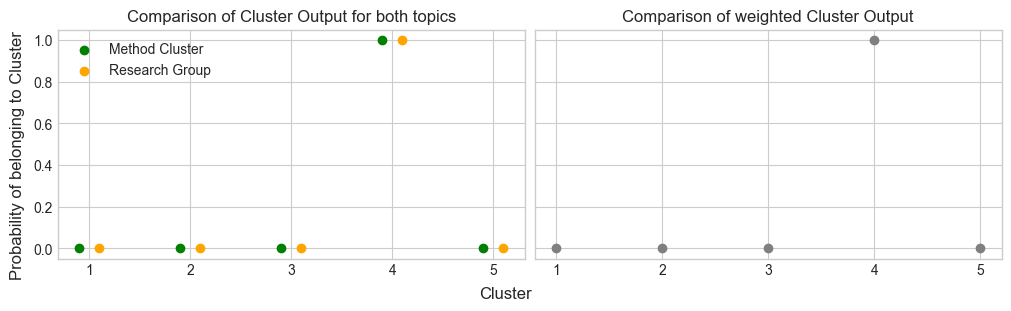

In [4]:
model.explainProbabilities(person=8)

The next graph shows the same information as dicussed above, only for all participants aggregated. In the best case, some clusters can already be identified here.

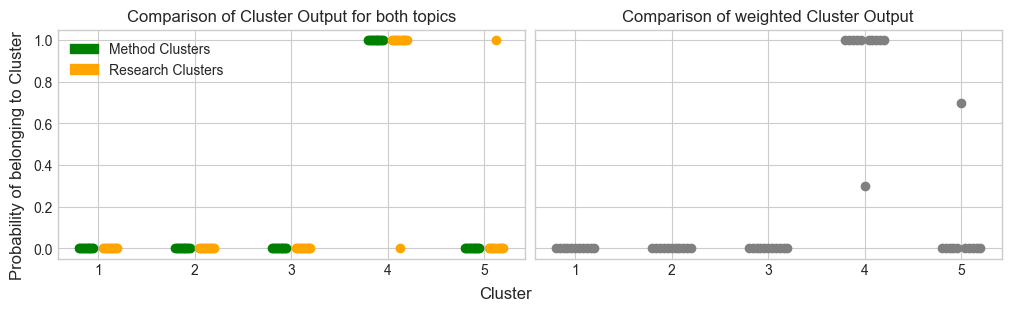

In [5]:
model.plotProbabilites()

Next, we turn to the final variable of interest being the desired Scope of the project. The boxplot below illustrates the preferences of all participants. Up to this point however, it does not contribute to the similarity group forming since we were not sure how to best include this information in the procedure so far. 

Hence, we implemented a second group forming procedure mainly based on this measure in a later stage.

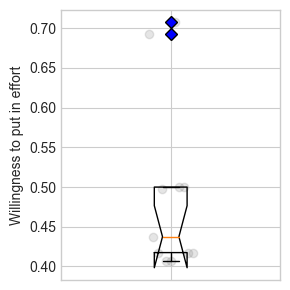

In [6]:
model.plotEffort()

### 4. Creating the Groups

We opted for three different procedures which can be used for creating the respective groups. All three will be outlined in the following:

The first groups are created on the basis of the similarity measures we calculated on the basis of models. Withe the `group_size`-parameter, one can adjust the desired number of groups and in the code, there is also the possibility to change the minimum/maximum number of participants within each of the groups:

In [7]:
model.recommend(kind="similar", group_size=3)

{'Group 1': [9],
 'Group 2': [8],
 'Group 3': [7],
 'Group 4': [0, 1, 2, 4],
 'Group 5': [5, 6, 3, 10]}

The second groups recommendations are based on the desired project scope. Therefore, we divided all participants answers into a fixed number of buckets determinded by `group_size` and made the group allocation accordingly.

In [8]:
model.recommend(kind="motivation", group_size=2)

{'Group 1': array([0, 3, 6, 7, 8]), 'Group 2': array([ 1,  2,  4,  5,  9, 10])}

Finally, there is also the possibility to create groups entirely randomly, where the `group_size`-parameter decides how many groups will be created.

In [9]:
model.recommend(kind="random", group_size=3)

{'Group 1': array([ 4, 10,  2]),
 'Group 2': array([0, 1, 7]),
 'Group 3': array([6, 9, 3]),
 'Group 4': array([5, 8])}